- Promediar las vtas de agosto 2019 (201908) como las de julio (201907) y septiembre (201909) para todas las observaciones
- Buscar los 'product_id' que tengan poca hitoria (agrupandolos por product_id y periodo y validar que tengan menos registros que training_trashold), eliminarlos del conjunto, y agregarlos el un dataframe "Predicciones", poniendo product_id junto con una columna "prediccion", que sea la media de las ventas de los periodos
- Aplicar LabelEncoder a las columnas categoricas
- Agrupar los restantes las ventas por periodo, cat1, cat2, cat3, marca y descripcion
- Calcular para estos el ratio de ventas por product_id (para cada grupo de cat1, cat2, cat3, marca y descripcion), guardando esto en un diccionario: cat1, cat2, cat3, marca, descripcion, product_id y ratio

----
- Agrupar las ventas por periodo, cat1, cat2, cat3, marca, descripcion y customer_id. Sumarizando los valores de las columnas cust_request_qty, cust_request_tn y tn.
- Aplicar escalers por columna a cada grupo (guardando estos scalers en un diccionario)
- Armar un modelo LSTM para predecir las ventas de cada uno de estos grupos (usando todas las observaciones menos las ultimas 2 para predecir la ultima )
----

- Luego, para cada grupo, hacer las predicciones con su modelo correspondiente (usando todas las observaciones menos las primeras 2). Guardando estas predicciones en un dataframe con la estructura cat1, cat2, cat3, marca, descripcion
- sumarizar las predicciones por cat1, cat2, cat3, marca, descripcion
- para cada cat1, cat2, cat3, marca, descripcion, buscar los product_id en el diccionario de ratios, aplicarlo sobre las predicciones sumarizadas, y armar un dataframe product_id y prediccion
- unificar este dataframe con el "Predicciones"
- guardar este df en un csv

#### Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

In [ ]:
df = pd.read_csv('../../Datasets/final_dataset_descr.csv', sep='\t')

In [ ]:
df.head()

#### Paso 3: Filtrar y eliminar productos con poca historia


Completamos el dataset con 0 para los producto / cliente que no existen

In [ ]:
# product_ids = [20001, 20002, 20003, 20004, 20005, 20006, 20007, 20008, 20009, 20010, 20011, 20012]

In [ ]:
# filtered_df = df[df['product_id'].isin(product_ids)]

In [ ]:
# display(filtered_df)

In [ ]:
df['periodo'] = pd.to_datetime(df['periodo'], format='%Y%m')

df = df[df['periodo'] >= '2018-12-01']

# Crear un DataFrame con información de productos (esto puede ser parte del dataset original)
product_info = df[['product_id', 'cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'descripcion']].drop_duplicates()

# Paso 2: Identificar el primer y último mes en que cada cliente compró cada producto
min_max_periods = df.groupby(['customer_id', 'product_id'])['periodo'].agg(['min', 'max']).reset_index()

# Crear una lista para almacenar los DataFrames generados
all_dfs = []

# Generar registros para cada combinación de customer_id y product_id
cont = 1

for _, row in min_max_periods.iterrows():
    customer_id = row['customer_id']
    product_id = row['product_id']
    min_period = row['min']
    max_period = '2019-12-01'
    all_periods = pd.date_range(min_period, max_period, freq='MS')
    
    combinations = pd.DataFrame({
        'customer_id': [customer_id] * len(all_periods),
        'product_id': [product_id] * len(all_periods),
        'periodo': all_periods
    })
    
    # Paso 3: Merge con el DataFrame original para identificar las combinaciones faltantes
    merged_df = pd.merge(combinations, df, on=['customer_id', 'product_id', 'periodo'], how='left')
    
    # Completar las combinaciones faltantes con tn = 0
    merged_df['tn'] = merged_df['tn'].fillna(0)
    
    merged_df['tn'] = merged_df['tn'].fillna(0)
    merged_df['cat1'] = merged_df['product_id'].map(product_info.set_index('product_id')['cat1'])
    merged_df['cat2'] = merged_df['product_id'].map(product_info.set_index('product_id')['cat2'])
    merged_df['cat3'] = merged_df['product_id'].map(product_info.set_index('product_id')['cat3'])
    merged_df['brand'] = merged_df['product_id'].map(product_info.set_index('product_id')['brand'])
    merged_df['sku_size'] = merged_df['product_id'].map(product_info.set_index('product_id')['sku_size'])
    merged_df['descripcion'] = merged_df['product_id'].map(product_info.set_index('product_id')['descripcion'])
    
    # Calcular las columnas 'quarter' y 'month' a partir del 'periodo'
    merged_df['quarter'] = 'Q' + merged_df['periodo'].dt.to_period('Q').astype(str).str[-1]
    merged_df['month'] = merged_df['periodo'].dt.month.astype(str).str.zfill(2)
    
    # Rellenar las demás columnas con valores predeterminados si es necesario
    merged_df['plan_precios_cuidados'] = merged_df['plan_precios_cuidados'].fillna(0)
    merged_df['cust_request_qty'] = merged_df['cust_request_qty'].fillna(0)
    merged_df['cust_request_tn'] = merged_df['cust_request_tn'].fillna(0)
    merged_df['close_quarter'] = merged_df['close_quarter'].fillna(0)
    merged_df['age'] = merged_df['age'].fillna(0)
    merged_df['mes_inicial'] = min_period
    
    # Agregar el DataFrame resultante a la lista
    all_dfs.append(merged_df)
    
    print(f"procesado {cont} de {len(min_max_periods)}")
    cont += 1

# Concatenar todos los DataFrames generados
df_full = pd.concat(all_dfs, ignore_index=True)

# Ordenar por customer_id, product_id y periodo
df_full = df_full.sort_values(by=['customer_id', 'product_id', 'periodo'])

# Convertir la columna 'periodo' de vuelta al formato original (YYYYMM)
df_full['periodo'] = df_full['periodo'].dt.strftime('%Y%m')

# Mostrar los resultados
display(df_full)

In [23]:
df_full.to_csv('final_dataset_completo_con_ceros.csv', sep='\t')

In [24]:
display(df_full)

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age,mes_inicial
0,10001,20001,201812,0.0,20.0,254.62373,254.62373,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q4,12,1.0,23.0,2018-12-01
1,10001,20001,201901,0.0,53.0,393.26092,386.60688,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,01,0.0,24.0,2018-12-01
2,10001,20001,201902,0.0,39.0,309.90610,309.90610,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,02,0.0,25.0,2018-12-01
3,10001,20001,201903,0.0,23.0,142.87158,130.54927,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q1,03,1.0,26.0,2018-12-01
4,10001,20001,201904,0.0,33.0,364.37071,364.37071,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,Q2,04,0.0,27.0,2018-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040578,10618,20845,201912,0.0,0.0,0.00000,0.00000,HC,PROFESIONAL,PISOS,MUSCULO,5000,Profesional menta,Q4,12,0.0,0.0,2019-11-01
2040579,10618,20886,201911,0.0,1.0,0.01884,0.01884,HC,PROFESIONAL,Gel,MUSCULO,5000,Industrial 5L,Q4,11,0.0,4.0,2019-11-01
2040580,10618,20886,201912,0.0,0.0,0.00000,0.00000,HC,PROFESIONAL,Gel,MUSCULO,5000,Industrial 5L,Q4,12,0.0,0.0,2019-11-01
2040581,10618,20953,201911,0.0,1.0,0.01817,0.01817,HC,PROFESIONAL,PISOS,MUSCULO,5000,Profesinal pisos plastificados,Q4,11,0.0,4.0,2019-11-01


#### Paso 4: Aplicar LabelEncoder a las columnas categóricas


In [25]:
categorical_cols = ['cat1', 'cat2', 'cat3', 'brand', 'descripcion', 'quarter']

# Aplicar LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_full[col] = le.fit_transform(df_full[col])
    label_encoders[col] = le

display(df_full)

,customer_id,product_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,quarter,month,close_quarter,age,mes_inicial
0,10001,20001,201812,0.0,20.0,254.62373,254.62373,1,10,47,0,3000,384,3,12,1.0,23.0,2018-12-01
1,10001,20001,201901,0.0,53.0,393.26092,386.60688,1,10,47,0,3000,384,0,01,0.0,24.0,2018-12-01
2,10001,20001,201902,0.0,39.0,309.90610,309.90610,1,10,47,0,3000,384,0,02,0.0,25.0,2018-12-01
3,10001,20001,201903,0.0,23.0,142.87158,130.54927,1,10,47,0,3000,384,0,03,1.0,26.0,2018-12-01
4,10001,20001,201904,0.0,33.0,364.37071,364.37071,1,10,47,0,3000,384,1,04,0.0,27.0,2018-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2040578,10618,20845,201912,0.0,0.0,0.00000,0.00000,1,8,54,21,5000,260,3,12,0.0,0.0,2019-11-01
2040579,10618,20886,201911,0.0,1.0,0.01884,0.01884,1,8,31,21,5000,158,3,11,0.0,4.0,2019-11-01
2040580,10618,20886,201912,0.0,0.0,0.00000,0.00000,1,8,31,21,5000,158,3,12,0.0,0.0,2019-11-01
2040581,10618,20953,201911,0.0,1.0,0.01817,0.01817,1,8,54,21,5000,256,3,11,0.0,4.0,2019-11-01


#### Paso 5: Agrupar y calcular el ratio de ventas por product_id


In [26]:
# Agrupar por las columnas relevantes
grouped_sales = df_full.groupby(['periodo', 'cat1', 'cat2', 'cat3', 'brand', 'product_id'])['tn'].sum().reset_index()
grouped_sales = grouped_sales[grouped_sales['periodo'] == '201912']

# Calcular el total de ventas por grupo
group_totals = grouped_sales.groupby(['periodo', 'cat1', 'cat2', 'cat3', 'brand'])['tn'].sum().reset_index()

# Unir para calcular el ratio
ratios = pd.merge(grouped_sales, group_totals, on=['periodo', 'cat1', 'cat2', 'cat3', 'brand'], suffixes=('', '_total'))

# Calcular el ratio
ratios['ratio'] = ratios['tn'] / ratios['tn_total']

# Crear un diccionario de ratios
ratio_dict = ratios.set_index(['cat1', 'cat2', 'cat3', 'brand', 'product_id'])['ratio'].to_dict()


In [27]:
display(ratio_dict)

{(0, 0, 4, 22, 20609): 1.0,
 (0, 0, 11, 22, 20266): 0.8902853590993973,
 (0, 0, 11, 22, 20325): 0.09463369678765542,
 (0, 0, 11, 22, 20503): 0.015080944112947194,
 (0, 0, 41, 18, 20299): 1.0,
 (0, 0, 41, 19, 20158): 1.0,
 (0, 0, 41, 22, 20033): 0.5843286913353127,
 (0, 0, 41, 22, 20095): 0.17227855901276462,
 (0, 0, 41, 22, 20119): 0.21901984451738263,
 (0, 0, 41, 22, 20242): 0.02437290513454,
 (0, 0, 48, 18, 20107): 0.5835676012609781,
 (0, 0, 48, 18, 20161): 0.2368165294241783,
 (0, 0, 48, 18, 20175): 0.13365037261349158,
 (0, 0, 48, 18, 20270): 0.04596549670135207,
 (0, 0, 48, 19, 20084): 0.28608061827647613,
 (0, 0, 48, 19, 20116): 0.35835342288529287,
 (0, 0, 48, 19, 20121): 0.23859655876074223,
 (0, 0, 48, 19, 20227): 0.11696940007748882,
 (0, 0, 48, 22, 20003): 0.3082454843319254,
 (0, 0, 48, 22, 20004): 0.2203131836596504,
 (0, 0, 48, 22, 20005): 0.2048903667719819,
 (0, 0, 48, 22, 20019): 0.12141472640344769,
 (0, 0, 48, 22, 20046): 0.051790796091872884,
 (0, 0, 48, 22, 20108)

#### Paso 6: Agrupar ventas por periodo, cat1, cat2, cat3, brand y customer_id


In [28]:
# Agrupar y sumarizar
grouped_df = df_full.groupby(['periodo', 'cat1', 'cat2', 'cat3', 'brand', 'customer_id', 'quarter', 'month']).agg({
    'cust_request_qty': 'sum',
    'cust_request_tn': 'sum',
    'tn': 'sum'
}).reset_index()


In [29]:
display(grouped_df)

,periodo,cat1,cat2,cat3,brand,customer_id,quarter,month,cust_request_qty,cust_request_tn,tn
0,201812,0,0,4,22,10001,3,12,6.0,0.87535,0.87535
1,201812,0,0,4,22,10002,3,12,8.0,0.27780,0.27780
2,201812,0,0,4,22,10003,3,12,1.0,0.27256,0.27256
3,201812,0,0,4,22,10004,3,12,1.0,0.13628,0.13628
4,201812,0,0,4,22,10005,3,12,7.0,0.06290,0.06290
...,...,...,...,...,...,...,...,...,...,...,...
434443,201912,3,13,82,32,10363,3,12,0.0,0.00000,0.00000
434444,201912,3,13,82,32,10367,3,12,0.0,0.00000,0.00000
434445,201912,3,13,82,32,10482,3,12,0.0,0.00000,0.00000
434446,201912,3,13,82,32,10513,3,12,0.0,0.00000,0.00000


Aplico DTW para agrupar los registros (series de categorias/clientes similares)

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt

pivoted_df = grouped_df.pivot_table(index=['cat1', 'cat2', 'cat3', 'brand', 'customer_id'], columns='periodo', values='tn').fillna(0)

# Escalar las series temporales
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # normalizar las series temporales
scaled_series = scaler.fit_transform(pivoted_df.values)
inertia = []
max_clusters = 15

for k in range(4, max_clusters + 1):
    print(f"Running K: {k}")
    model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
    model.fit(scaled_series)
    inertia.append(model.inertia_)


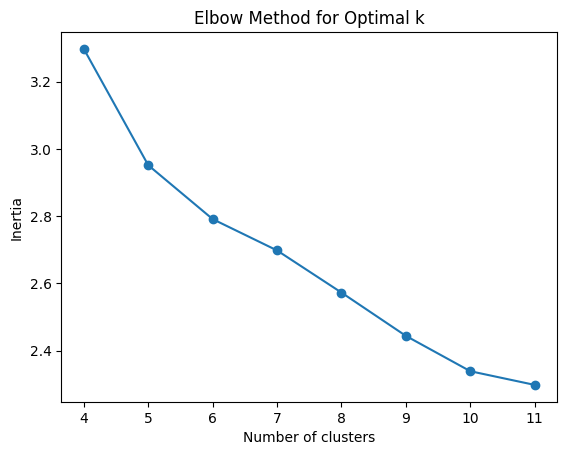

In [33]:
plt.plot(range(4, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [34]:
n_clusters = 12 #TODO: Correr con 15
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
cluster_labels = model.fit_predict(scaled_series)

# Paso 4: Asignar el número de grupo a cada elemento de grouped_df
pivoted_df['cluster'] = cluster_labels

# Unir el número de grupo con grouped_df
grouped_df = grouped_df.merge(pivoted_df['cluster'], left_on=['cat1', 'cat2', 'cat3', 'brand', 'customer_id'], right_index=True)

# Guardar el resultado en un archivo CSV (opcional)
grouped_df.to_csv('grouped_with_clusters.csv', index=False)

# Mostrar el DataFrame final con los números de grupo
display(grouped_df)

,periodo,cat1,cat2,cat3,brand,customer_id,quarter,month,cust_request_qty,cust_request_tn,tn,cluster
0,201812,0,0,4,22,10001,3,12,6.0,0.87535,0.87535,9
1,201812,0,0,4,22,10002,3,12,8.0,0.27780,0.27780,11
2,201812,0,0,4,22,10003,3,12,1.0,0.27256,0.27256,6
3,201812,0,0,4,22,10004,3,12,1.0,0.13628,0.13628,6
4,201812,0,0,4,22,10005,3,12,7.0,0.06290,0.06290,4
...,...,...,...,...,...,...,...,...,...,...,...,...
434443,201912,3,13,82,32,10363,3,12,0.0,0.00000,0.00000,3
434444,201912,3,13,82,32,10367,3,12,0.0,0.00000,0.00000,9
434445,201912,3,13,82,32,10482,3,12,0.0,0.00000,0.00000,3
434446,201912,3,13,82,32,10513,3,12,0.0,0.00000,0.00000,3


#### Paso 7: Aplicar escalers por columna a cada grupo


In [35]:
# Crear un diccionario para almacenar los scalers
scalers = {}
scaled_df = grouped_df.copy()

# Aplicar StandardScaler a cada columna de interés
for col in ['cust_request_qty', 'cust_request_tn', 'tn']:
    scaler = StandardScaler()
    scaled_df[col] = scaler.fit_transform(scaled_df[[col]])
    scalers[col] = scaler

# Guardar los scalers para su uso posterior
joblib.dump(scalers, 'scalers.pkl')


['scalers.pkl']

In [36]:
display(scaled_df)

,periodo,cat1,cat2,cat3,brand,customer_id,quarter,month,cust_request_qty,cust_request_tn,tn,cluster
0,201812,0,0,4,22,10001,3,12,0.105941,-0.003594,-0.000746,9
1,201812,0,0,4,22,10002,3,12,0.222702,-0.081610,-0.081700,11
2,201812,0,0,4,22,10003,3,12,-0.185960,-0.082294,-0.082410,6
3,201812,0,0,4,22,10004,3,12,-0.185960,-0.100087,-0.100873,6
4,201812,0,0,4,22,10005,3,12,0.164321,-0.109667,-0.110814,4
...,...,...,...,...,...,...,...,...,...,...,...,...
434443,201912,3,13,82,32,10363,3,12,-0.244341,-0.117880,-0.119335,3
434444,201912,3,13,82,32,10367,3,12,-0.244341,-0.117880,-0.119335,9
434445,201912,3,13,82,32,10482,3,12,-0.244341,-0.117880,-0.119335,3
434446,201912,3,13,82,32,10513,3,12,-0.244341,-0.117880,-0.119335,3


In [42]:
scaled_df.dtypes

periodo              object
cat1                  int64
cat2                  int64
cat3                  int64
brand                 int64
customer_id           int64
quarter               int64
month                object
cust_request_qty    float64
cust_request_tn     float64
tn                  float64
cluster               int64
dtype: object

#### Paso 8: Armar un modelo LSTM


In [103]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.regularizers import l2
import numpy as np

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(256, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True))
    model.add(Dropout(0.2))
    # model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True))
    # model.add(Dropout(0.2))
    model.add(LSTM(256, activation='tanh', kernel_regularizer=l2(0.1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128, activation='tanh', kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # model.compile(optimizer='adam', loss='mse')
    # return model
    # model = Sequential()
    # model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=input_shape))
    # model.add(Dropout(0.2))
    # model.add(LSTM(128, activation='relu', return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(64, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

#### Paso 9: Entrenar y predecir con el modelo LSTM para cada grupo


In [ ]:
from keras.callbacks import ReduceLROnPlateau

models = {}
predictions = []

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001, verbose=1)
scaler_tn = scalers['tn']

# Preparar los datos por cluster
for cluster in range(n_clusters):
    display(f'Entrenando cluster numero: {cluster}')
    cluster_data = scaled_df[scaled_df['cluster'] == cluster].copy()
    cluster_data.sort_values(by='periodo', inplace=True)
    
    # Preparar los datos para LSTM
    X, y = [], []
    for key, data in cluster_data.groupby(['cat1', 'cat2', 'cat3', 'brand', 'customer_id']):
        series = data[['quarter', 'month', 'tn']].values
        if len(series) > 2:  # Asegurarse de que haya suficientes datos
            X.append(series[:-2])  # Todos los datos excepto los últimos 2
            y.append(series[-1, -1])
    
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.float32)
    
    if len(X) == 0 or len(y) == 0:
        continue
    
    # Construir y entrenar el modelo
    model = build_lstm_model((X.shape[1], X.shape[2]))
    model.fit(X, y, epochs=100, verbose=2, batch_size=128, validation_split=0.2, callbacks=[reduce_lr])
    models[cluster] = model
    
    # Hacer predicciones
    for key, data in cluster_data.groupby(['cat1', 'cat2', 'cat3', 'brand', 'customer_id']):
        series = data[['quarter', 'month', 'tn']].values
        
        if len(series) > 2:
            X_pred = series.astype(np.float32)
            X_pred = np.reshape(X_pred, (1, X_pred.shape[0], X_pred.shape[1]))
            pred = model.predict(X_pred, verbose=2)
            inverse_pred = scaler_tn.inverse_transform(pred)[0][0]
            # display(inverse_pred)
            predictions.append([key[0], key[1], key[2], key[3], inverse_pred, key[4]])


#### Paso 10: Sumarizar las predicciones y aplicar ratios


In [65]:
pred_df = pd.DataFrame(predictions, columns=['cat1', 'cat2', 'cat3', 'brand', 'prediccion', 'customer_id'])

# Sumarizar las predicciones por grupo
summarized_preds = pred_df.groupby(['cat1', 'cat2', 'cat3', 'brand'])['prediccion'].sum().reset_index()

# Aplicar los ratios para obtener las predicciones finales por product_id
final_predictions = []
for _, row in summarized_preds.iterrows():
    key = (row['cat1'], row['cat2'], row['cat3'], row['brand'])
    for (cat1, cat2, cat3, brand, product_id), ratio in ratio_dict.items():
        if (cat1, cat2, cat3, brand) == key:
            final_predictions.append([product_id, row['prediccion'] * ratio])

# Convertir las predicciones finales a un DataFrame
final_predictions_df = pd.DataFrame(final_predictions, columns=['product_id', 'prediccion'])

# Guardar el resultado en un archivo CSV
final_predictions_df.to_csv('predicciones_finales.csv', index=False)

# Mostrar el DataFrame final con las predicciones
display(final_predictions_df)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.